## Imports

In [1]:
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from GolfField import GolfField, Point, Ball
from GolfEnv import GolfEnv, GolfEnv8d1p, GolfEnvDP
from utils import QNetwork, MinimumExponentialLR, EpsilonGreedy, ReplayBuffer, train_dqn2_agent, get_episode_len, train_naive_agent

%load_ext autoreload
%autoreload 2

In [9]:
def get_episode_len1(env, q_network, epsilon_greedy, device='cpu'):
    state, info = env.reset()
    episode_len = 0
    
    min_pw = 100
    max_pw = -1
        
    for t in itertools.count():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_dist = q_network(state_tensor).squeeze()
        action = epsilon_greedy(state)
        
        min_pw = min(min_pw, action // 8 + 1)
        max_pw = max(max_pw, action // 8 + 1)

        state, reward, done, truncated, _ = env.step(action)
        if done:
            break
        episode_len += 1
    
#     print(f'min: {min_pw}, max: {max_pw}')
    return episode_len

## n_angles = 8, n_power = 4

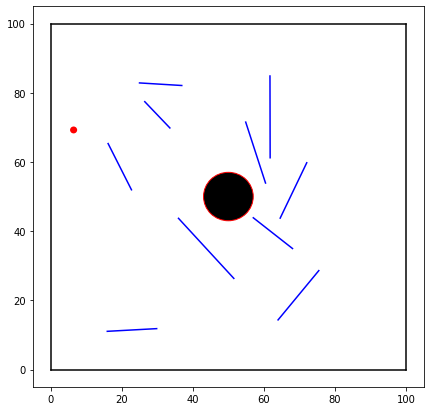

In [22]:
n_angles = 8
n_power = 4

# env = GolfEnvDP(0, 10, lambda old_dist, new_dist: ((new_dist < old_dist) * 2 - 1) * 100 - 90, n_angles, n_power)
env = GolfEnvDP(0, 10, lambda old_dist, new_dist: ((new_dist < old_dist) * 2 - 1) * (new_dist - old_dist)**2, n_angles, n_power)
env.field.hole_R = 7
env.reset()
env.field.hole = Ball(Point(50, 50), 7)
env.render()

In [23]:
device = 'cpu'

state_dim = 2
action_dim = n_angles * n_power

q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network.load_state_dict(q_network.state_dict())

optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

replay_buffer = ReplayBuffer(2000)

In [65]:
episode_reward_list = train_dqn2_agent(env,
                                       q_network,
                                       target_q_network,
                                       optimizer,
                                       loss_fn,
                                       epsilon_greedy,
                                       device,
                                       lr_scheduler,
                                       num_episodes=5000,
                                       gamma=0.9,
                                       batch_size=128,
                                       replay_buffer=replay_buffer,
                                       target_q_network_sync_period=30)

  1%|          | 49/4999 [00:03<04:48, 17.16it/s]

1278.894280496187


  2%|▏         | 103/4999 [00:07<04:31, 18.06it/s]

1246.8080852810274


  3%|▎         | 150/4999 [00:10<06:02, 13.37it/s]

1211.5111062534327


  4%|▍         | 204/4999 [00:13<03:10, 25.21it/s]

1246.3736981643049


  5%|▌         | 256/4999 [00:16<03:07, 25.26it/s]

1283.4966203041317


  6%|▌         | 298/4999 [00:18<05:08, 15.24it/s]

1308.1856120182167


  7%|▋         | 350/4999 [00:23<03:32, 21.90it/s]

1242.1982811482364


  8%|▊         | 401/4999 [00:27<04:52, 15.72it/s]

1255.2567300119224


  9%|▉         | 451/4999 [00:31<08:21,  9.06it/s]

1245.3146865308893


 10%|█         | 501/4999 [00:34<02:43, 27.51it/s]

1286.5586651392293


 11%|█         | 549/4999 [00:38<05:50, 12.69it/s]

1266.6292123708076


 12%|█▏        | 600/4999 [3:41:58<21:43,  3.37it/s]       

1229.5265990354333


 13%|█▎        | 650/4999 [3:42:05<11:15,  6.43it/s]

1296.2341238162


 14%|█▍        | 699/4999 [3:42:12<07:00, 10.23it/s]

1268.2740479249771


 15%|█▌        | 750/4999 [3:42:19<09:07,  7.76it/s]

1252.7693598547805


 16%|█▌        | 800/4999 [3:42:22<03:31, 19.86it/s]

1274.9084284802816


 17%|█▋        | 850/4999 [3:42:27<09:15,  7.47it/s]

1271.7279340796383


 18%|█▊        | 899/4999 [3:42:30<08:48,  7.75it/s]

1294.5478440052784


 19%|█▉        | 951/4999 [3:42:35<04:23, 15.36it/s]

1294.2251201190018


 20%|█▉        | 998/4999 [3:42:40<04:44, 14.05it/s]

1257.2626437395322


 21%|██        | 1048/4999 [3:42:45<03:00, 21.91it/s]

1237.3797815681626


 22%|██▏       | 1101/4999 [3:42:50<04:47, 13.55it/s]

1251.9336724601576


 23%|██▎       | 1152/4999 [3:42:55<05:10, 12.39it/s]

1270.6271713159556


 24%|██▍       | 1199/4999 [3:43:02<06:57,  9.10it/s]

1238.2302196848568


 25%|██▌       | 1254/4999 [3:43:10<09:05,  6.86it/s]

1237.1211434549957


 26%|██▌       | 1299/4999 [3:43:14<05:33, 11.09it/s]

1293.2648573544864


 27%|██▋       | 1347/4999 [3:43:17<02:26, 24.97it/s]

1294.0782418642764


 28%|██▊       | 1399/4999 [3:43:24<05:28, 10.96it/s]

1306.6721977221512


 29%|██▉       | 1451/4999 [3:43:34<07:48,  7.57it/s]

1262.2655801942515


 30%|███       | 1501/4999 [3:43:38<03:47, 15.35it/s]

1272.3581532244625


 31%|███       | 1550/4999 [3:43:44<07:47,  7.37it/s]

1263.1478797178954


 32%|███▏      | 1599/4999 [3:43:52<07:01,  8.07it/s]

1190.5981665570546


 33%|███▎      | 1651/4999 [3:44:00<04:27, 12.51it/s]

1241.4015770589601


 34%|███▍      | 1700/4999 [3:44:05<04:21, 12.63it/s]

1273.9570651842241


 35%|███▌      | 1751/4999 [3:44:11<04:13, 12.83it/s]

1266.7149839010215


 36%|███▌      | 1799/4999 [3:44:16<03:14, 16.47it/s]

1251.5876866832577


 37%|███▋      | 1850/4999 [3:44:22<05:25,  9.67it/s]

1294.9027923524764


 38%|███▊      | 1900/4999 [3:44:28<05:20,  9.66it/s]

1298.1301737854074


 39%|███▉      | 1950/4999 [3:44:35<10:28,  4.85it/s]

1250.2235741336835


 40%|███▉      | 1999/4999 [3:44:40<04:46, 10.46it/s]

1274.8006454010124


 41%|████      | 2053/4999 [3:44:44<01:54, 25.65it/s]

1249.0602178243985


 42%|████▏     | 2098/4999 [3:44:50<03:23, 14.23it/s]

1270.2020856149215


 43%|████▎     | 2150/4999 [3:44:56<03:16, 14.51it/s]

1237.298228794684


 44%|████▍     | 2200/4999 [3:45:01<03:39, 12.72it/s]

1295.7604952997174


 45%|████▌     | 2250/4999 [3:45:05<04:22, 10.47it/s]

1271.4739754523048


 46%|████▌     | 2299/4999 [3:45:11<06:10,  7.28it/s]

1231.612229517757


 47%|████▋     | 2351/4999 [3:45:22<04:55,  8.95it/s]

1190.7908513815664


 48%|████▊     | 2400/4999 [3:45:33<05:31,  7.85it/s]

1217.0391246021857


 49%|████▉     | 2449/4999 [3:45:40<03:05, 13.76it/s]

1285.1298216644273


 50%|████▉     | 2499/4999 [3:45:48<04:21,  9.55it/s]

1236.4178936986377


 51%|█████     | 2551/4999 [3:45:53<03:16, 12.44it/s]

1250.9389867696048


 52%|█████▏    | 2601/4999 [3:45:59<03:11, 12.51it/s]

1252.0197743024457


 53%|█████▎    | 2650/4999 [3:46:04<05:01,  7.79it/s]

1253.1126486499204


 54%|█████▍    | 2700/4999 [3:46:13<04:59,  7.68it/s]

1258.9618725949922


 55%|█████▌    | 2751/4999 [3:46:20<03:21, 11.14it/s]

1273.7714718713519


 56%|█████▌    | 2800/4999 [3:46:31<08:31,  4.30it/s]

1212.3264391583214


 57%|█████▋    | 2849/4999 [3:46:35<04:42,  7.61it/s]

1270.7500330056641


 58%|█████▊    | 2901/4999 [3:46:42<03:48,  9.19it/s]

1301.181684919112


 59%|█████▉    | 2950/4999 [3:46:47<03:35,  9.50it/s]

1235.271695461399


 60%|██████    | 3000/4999 [3:46:54<02:21, 14.10it/s]

1255.3019108460608


 61%|██████    | 3051/4999 [3:47:01<03:28,  9.32it/s]

1266.5621665545964


 62%|██████▏   | 3100/4999 [3:47:09<03:21,  9.41it/s]

1197.8702307326344


 63%|██████▎   | 3150/4999 [3:47:15<04:08,  7.44it/s]

1279.06912255002


 64%|██████▍   | 3202/4999 [3:47:20<02:28, 12.09it/s]

1300.8220604993946


 65%|██████▌   | 3250/4999 [3:47:25<02:52, 10.13it/s]

1277.1553426298715


 66%|██████▌   | 3301/4999 [3:47:30<02:12, 12.78it/s]

1273.6703877507512


 67%|██████▋   | 3351/4999 [3:47:36<05:28,  5.02it/s]

1277.035062640941


 68%|██████▊   | 3401/4999 [3:47:42<03:23,  7.85it/s]

1262.2104938965576


 69%|██████▉   | 3449/4999 [3:47:46<02:21, 10.93it/s]

1261.7607074672837


 70%|███████   | 3501/4999 [3:47:53<02:14, 11.13it/s]

1229.93596432287


 71%|███████   | 3549/4999 [3:47:59<02:07, 11.40it/s]

1258.9982617676803


 72%|███████▏  | 3601/4999 [3:48:04<02:12, 10.58it/s]

1261.6002983493238


 73%|███████▎  | 3650/4999 [3:48:09<01:58, 11.37it/s]

1272.600429637306


 74%|███████▍  | 3700/4999 [3:48:16<02:26,  8.85it/s]

1236.2232048714964


 75%|███████▌  | 3751/4999 [3:48:21<02:02, 10.18it/s]

1237.3359027728259


 76%|███████▌  | 3799/4999 [3:48:26<01:46, 11.23it/s]

1251.8671466543587


 77%|███████▋  | 3848/4999 [3:48:31<01:49, 10.48it/s]

1282.9690790167201


 78%|███████▊  | 3900/4999 [3:48:37<02:29,  7.36it/s]

1249.7940059116365


 79%|███████▉  | 3951/4999 [3:48:44<03:18,  5.28it/s]

1259.3842650841061


 80%|████████  | 4000/4999 [3:48:53<01:49,  9.14it/s]

1251.7758347194822


 81%|████████  | 4051/4999 [3:49:00<02:10,  7.25it/s]

1299.1877330589655


 82%|████████▏ | 4100/4999 [3:49:07<01:22, 10.84it/s]

1278.2112608213847


 83%|████████▎ | 4150/4999 [3:49:12<01:37,  8.73it/s]

1269.6467007212325


 84%|████████▍ | 4200/4999 [3:49:18<01:12, 11.06it/s]

1257.5043522548417


 85%|████████▌ | 4251/4999 [3:49:26<03:54,  3.19it/s]

1255.737424429096


 86%|████████▌ | 4300/4999 [3:49:31<01:12,  9.71it/s]

1276.7339340324475


 87%|████████▋ | 4351/4999 [3:49:37<01:20,  8.08it/s]

1294.7070685039043


 88%|████████▊ | 4399/4999 [3:49:44<01:11,  8.36it/s]

1256.2958193023328


 89%|████████▉ | 4451/4999 [3:49:54<01:14,  7.32it/s]

1276.3273260198944


 90%|████████▉ | 4498/4999 [3:50:00<00:39, 12.70it/s]

1260.5675111576168


 91%|█████████ | 4551/4999 [3:50:05<00:41, 10.90it/s]

1274.3677477389094


 92%|█████████▏| 4601/4999 [3:50:15<00:49,  8.09it/s]

1205.7984212533474


 93%|█████████▎| 4651/4999 [3:50:20<00:37,  9.19it/s]

1263.1360696992447


 94%|█████████▍| 4699/4999 [3:50:24<00:27, 10.98it/s]

1310.8895190517737


 95%|█████████▌| 4750/4999 [3:50:29<00:24, 10.35it/s]

1299.285030249225


 96%|█████████▌| 4799/4999 [3:50:34<00:34,  5.80it/s]

1264.562701913767


 97%|█████████▋| 4850/4999 [3:50:40<00:18,  8.15it/s]

1272.2358528540667


 98%|█████████▊| 4899/4999 [3:50:47<00:13,  7.35it/s]

1244.0373602859536


 99%|█████████▉| 4950/4999 [3:50:54<00:04, 10.12it/s]

1281.186333343922


100%|██████████| 4999/4999 [3:51:00<00:00,  2.77s/it]

1258.394012720407


In [64]:
lens = np.array([get_episode_len1(env, q_network, epsilon_greedy) for i in tqdm(range(100))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 100/100 [00:03<00:00, 30.30it/s]

Mean route len: 7.48
Success rate: 1.0


5


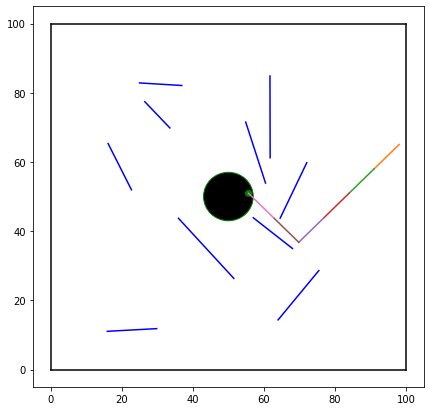

In [56]:
print(get_episode_len(env, q_network, epsilon_greedy))
env.render()

6
4
7
14
6
8
10
6
18
9
5
6


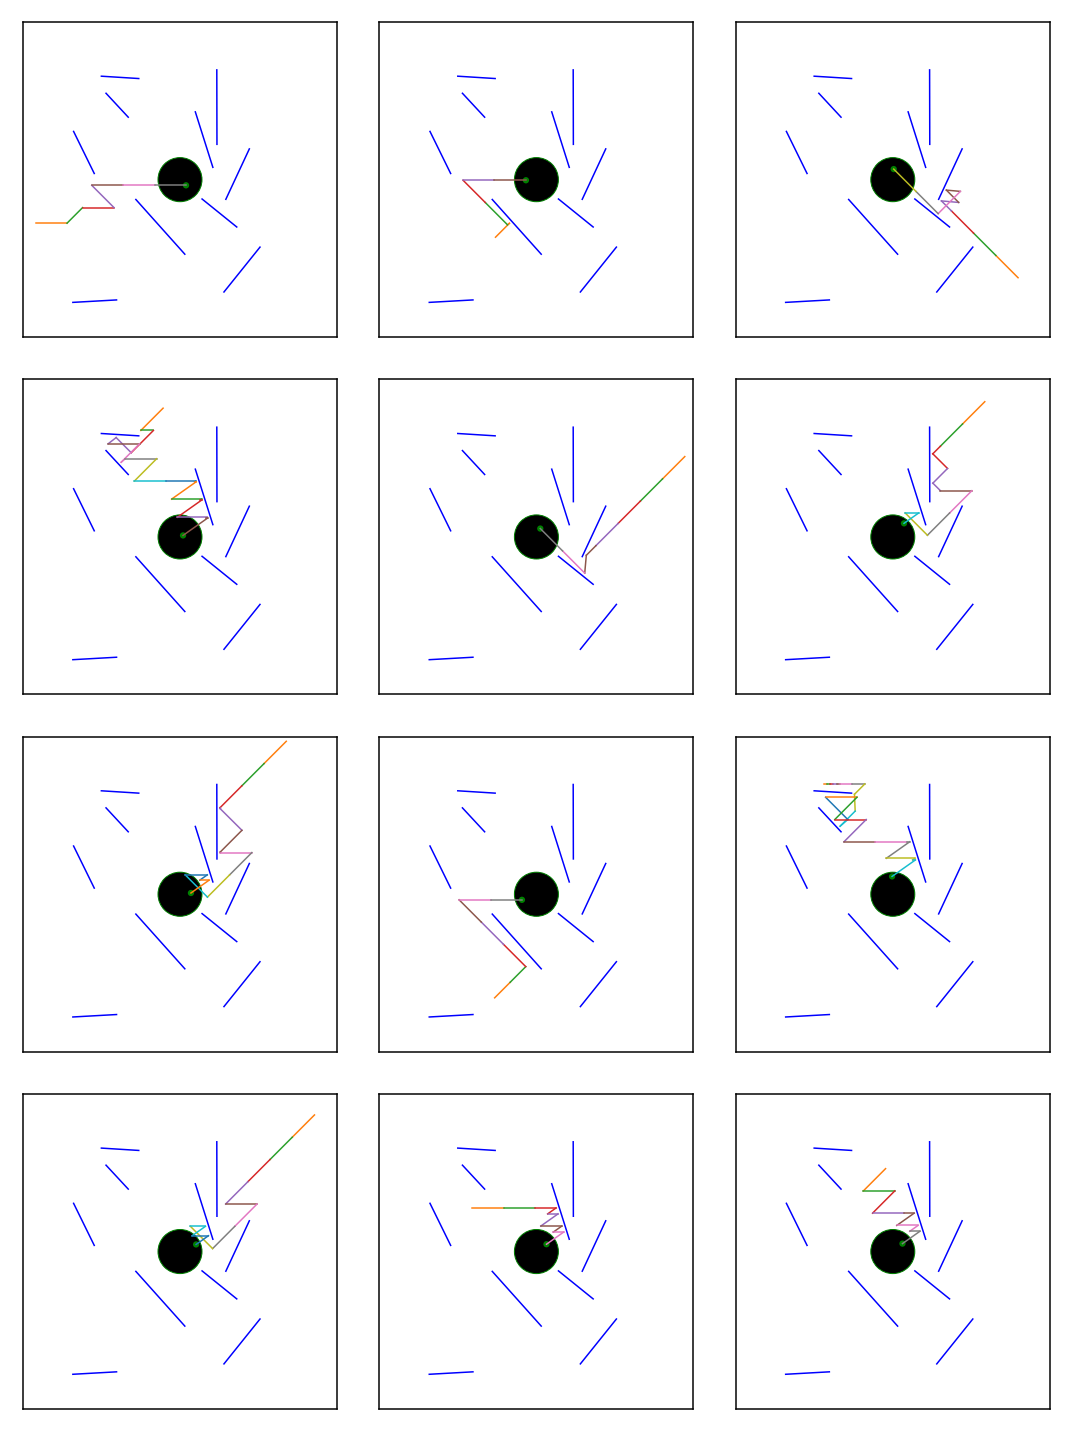

In [58]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ln = get_episode_len1(env, q_network, epsilon_greedy)
    print(ln)

    env.render(ax)
    ax.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


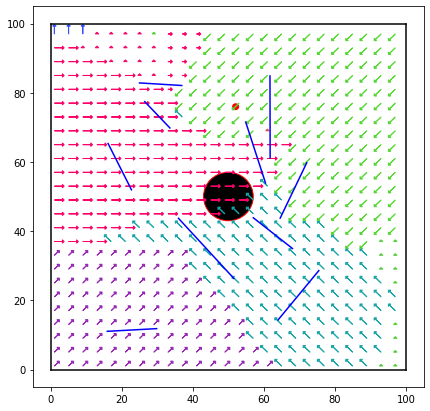

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 7))

func_for_action = lambda x, y: (
    (q_network(torch.tensor([x, y], dtype=torch.float32)).squeeze().argmax().item() % 8) * (360 / 8),
    (q_network(torch.tensor([x, y], dtype=torch.float32)).squeeze().argmax().item() // 8)
)

func_for_action(40, 30)
env.render_wind(func_for_action, ax)

In [60]:
torch.save(q_network, "dqn_d8p10_q_network_099.pth")

In [62]:
env.reset()

(array([52.04, 75.98], dtype=float32),
 {'track': [([[52.04 75.98], 1], 0)], 'current_step': 0})